# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведем исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
!pip install missingno
import missingno as msno

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep="\t") # в качестве разделителя табуляция
data.info() # общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
data.head(4)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0


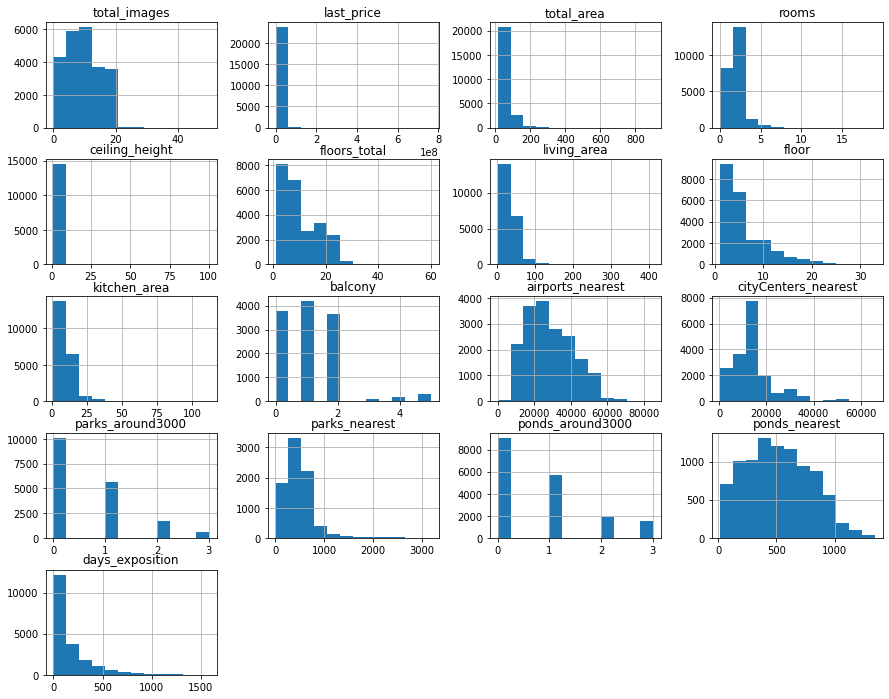

In [4]:
# Строим гистограммы
data.hist(figsize=(15, 12), bins=12)

plt.show()

После изучения общей информации о датасете, можно сказать, что в данных представлено 22 столбца и 23699 строк. Таблица содержит числовые, категориальные и логические данные. В некоторых столбцах имеются пропущенные значения, в частности, в `ceiling_height`, `living_area`, `kitchen_area`, `balcony`, `locality_name`, `airports_nearest`, `cityCenters_nearest`, `parks_nearest`, `ponds_nearest` и `days_exposition`. 

Анализ первых строк показывает, что данные описывают характеристики объектов недвижимости, такие как площадь, количество комнат, наличие балкона, расстояния до ближайших объектов инфраструктуры, высота потолков, а также цена. Видно, что в данных есть пропуски, например, в столбцах `is_apartment` и `days_exposition`.

Распределение данных по гистограммам демонстрирует, что имеются выбивающиеся значения (выбросы).

Для дальнейшего анализа необходимо обработать пропущенные значения, исследовать выбросы.

### Выполним предобработку данных

In [5]:
# подсчёт пропусков
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

<AxesSubplot:>

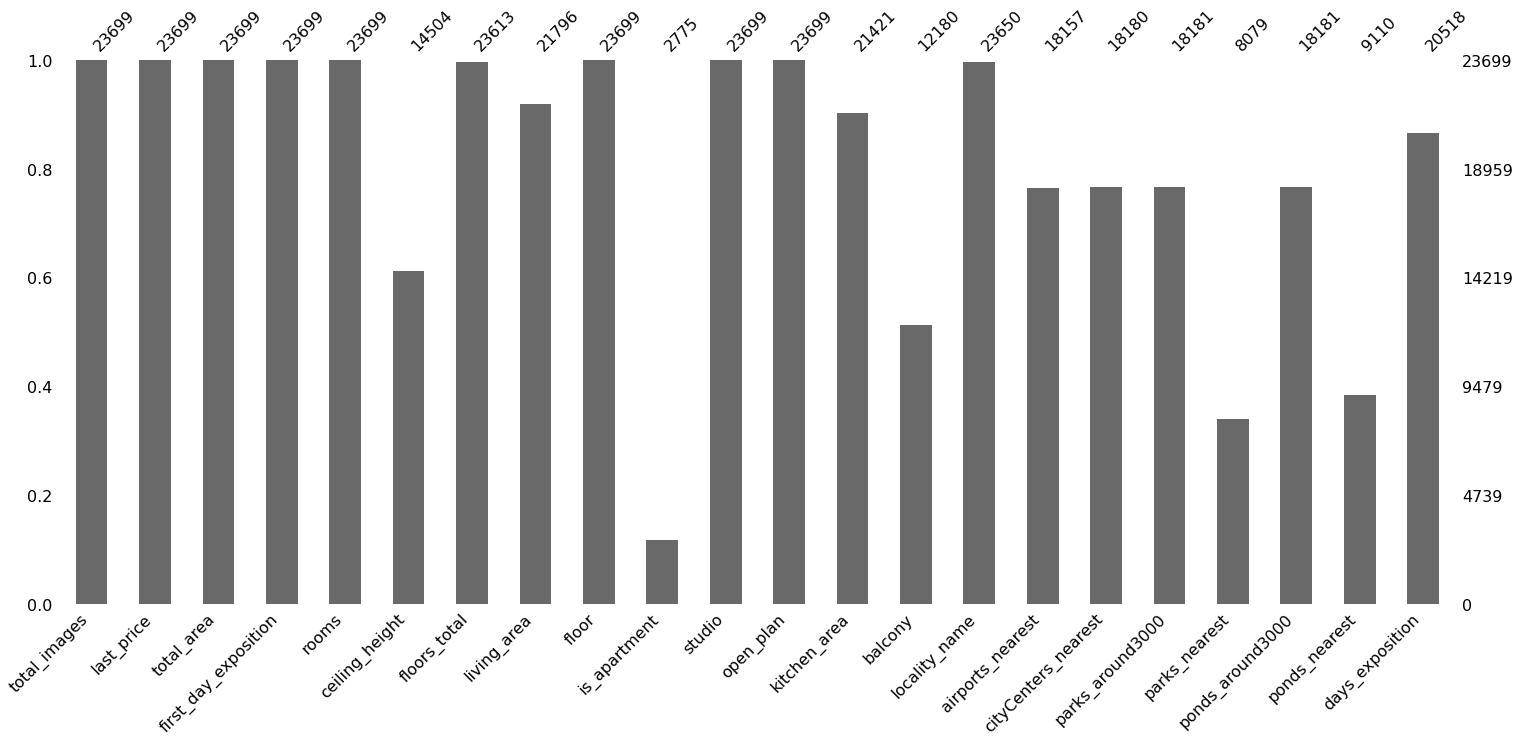

In [6]:
# Гистограмму можно использовать, чтобы более интуитивно увидеть соотношение и количество пропущенных переменных.
msno.bar(data)

#### Замена пропущенных значений

In [7]:
# нет True и слишком много пропусков, делаем вывод что пропущенные значения это True
data['is_apartment'] = data['is_apartment'].fillna(True)

In [8]:
# если продавец не указал число балконов, то, скорее всего, в его квартире их нет
data['balcony'] = data['balcony'].fillna(0)

In [9]:
# замена пропущенных значений на 'unknown'
data['locality_name'] = data['locality_name'].fillna('unknown')

In [10]:
# если не указан ближайший парк но есть хоть один парк в радиусе 3 км то указываем ближайший в радиусе 3000 м
data.loc[data['parks_around3000'] >= 1, 'parks_nearest'] = data['parks_nearest'].fillna('3000')
# аналогично с водоемами
data.loc[data['ponds_around3000'] >= 1, 'ponds_nearest'] = data['ponds_nearest'].fillna('3000')

In [11]:
# если продавец не указал число парков или водоемов рядом, то, скорее всего, их нет
data['ponds_around3000'] = data['ponds_around3000'].fillna('0')
data['parks_around3000'] = data['parks_around3000'].fillna('0')

In [12]:
# контрольный подсчёт пропусков
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

Причины, которые могли привести к пропускам в данных:

1. **Необязательности заполнения** — пользователи могли не указывать параметры, например, **is_apartment** или **балкон**, если они казались неважными.  
2. **Ошибок при сборе данных** — технические сбои или отсутствие геолокации могли препятствовать расчету расстояний до объектов.  
3. **Человеческого фактора** — авторы объявлений могли забыть или намеренно не заполнять поля, например, **высоту потолков**.  
4. **Недоступности информации** — данные могут отсутствовать для объектов в удаленных районах без парков или водоемов поблизости.  
5. **Различий в стандартах** — менее строгие требования платформ к заполнению некоторых полей, например, площади кухни.  
6. **Проблем интеграции** — несоответствия при объединении данных из разных источников.


#### Работа с типами данных в каждом столбце

In [13]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000         object
parks_nearest            object
ponds_around3000         object
ponds_nearest            object
days_exposition         float64
dtype: object

In [14]:
# преобразование даты в datetime64[ns]
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

In [15]:
# преобразование количества этажей в доме в тип Int64, который поддерживает NaN 
data['floors_total'] = data['floors_total'].astype(pd.Int64Dtype())

In [16]:
# преобразование количества балконов в квартире
data['balcony'] = data['balcony'].astype(int)

In [17]:
# преобразование количества парков и водоемов в радиусе 3 км
data['parks_around3000'] = data['parks_around3000'].astype(int)
data['ponds_around3000'] = data['ponds_around3000'].astype(int)

In [18]:
data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     Int64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000                 int64
parks_nearest                   object
ponds_around3000                 int64
ponds_nearest                   object
days_exposition                float64
dtype: object

Изменение типов данных необходимо для корректного анализа и обработки данных. 

1. **`first_day_exposition → datetime64[ns]`**  
   - Тип `datetime` позволяет эффективно работать с датами: рассчитывать промежутки времени, фильтровать по диапазонам дат и т.д.

2. **`floors_total → Int64`**  
   - Переход на `Int64` (поддерживает пропуски) вместо `float64` позволяет корректно работать с целыми числами и пропущенными значениями.

3. **`balcony → int64`**  
   - Замена `object` на `int64` упрощает подсчеты и анализ. Например, можно легко посчитать среднее число балконов. Пропуски можно интерпретировать как 0 балконов.

4. **`parks_around3000, ponds_around3000 → int64`**  
   - Числовой тип данных более логичен для подсчета объектов в радиусе. Это позволяет выполнять математические операции и агрегировать данные.

5. **Прочие булевы поля (`is_apartment`, `studio`, `open_plan`)**  
   - Булев тип удобнее для логических операций и фильтрации данных.

Изменение типов данных позволяет улучшить производительность, снизить вероятность ошибок и расширить возможности анализа.


#### Работа с уникальными значениями в столбце с названиями и устранение неявных дубликатов. Например, «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов. 

In [19]:
# подсчёт явных дубликатов
data.duplicated().sum()

0

In [20]:
# просмотр уникальных locality_name
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [21]:
# подсчет уникальных locality_name
len(data['locality_name'].unique())

365

In [22]:
# только деревни
villages = data[data['locality_name'].str.contains('деревня')]
print(villages['locality_name'].unique())

['деревня Кудрово' 'деревня Фёдоровское' 'деревня Новое Девяткино'
 'деревня Пикколово' 'деревня Куттузи' 'деревня Заклинье' 'деревня Старая'
 'деревня Лесколово' 'деревня Оржицы' 'деревня Кальтино' 'деревня Нурма'
 'деревня Лопухинка' 'деревня Кипень' 'деревня Келози' 'деревня Вартемяги'
 'деревня Агалатово' 'деревня Лаголово' 'деревня Белогорка'
 'деревня Большие Колпаны' 'деревня Горбунки' 'деревня Батово'
 'деревня Заневка' 'деревня Иссад' 'деревня Мистолово'
 'деревня Разметелево' 'деревня Пеники' 'деревня Пудомяги'
 'деревня Низино' 'деревня Бегуницы' 'деревня Колтуши' 'деревня Гостилицы'
 'деревня Малое Карлино' 'деревня Аро' 'деревня Малое Верево'
 'деревня Извара' 'деревня Калитино' 'деревня Чудской Бор' 'деревня Мины'
 'деревня Коркино' 'деревня Рабитицы' 'деревня Кузьмолово'
 'деревня Малые Колпаны' 'деревня Меньково' 'деревня Старые Бегуницы'
 'деревня Гарболово' 'деревня Юкки' 'деревня Мануйлово' 'деревня Пчева'
 'деревня Кривко' 'деревня Парицы' 'деревня Лампово' 'деревня

In [23]:
# только поселки

# Словарь замен
replacements = {
    'ё': 'е',
    'поселок городского типа': 'поселок',
    'городской поселок': 'поселок',
    'поселок при железнодорожной станции': 'поселок',
    'коттеджный поселок': 'поселок',
    'поселок станции': 'поселок'
}

for old_value, new_value in replacements.items():
    data['locality_name'] = data['locality_name'].str.replace(old_value, new_value)

township = data[data['locality_name'].str.contains('поселок')]
print(township['locality_name'].unique())

['поселок Шушары' 'поселок Янино-1' 'поселок Парголово' 'поселок Мурино'
 'поселок Красный Бор' 'поселок Металлострой' 'поселок Лебяжье'
 'поселок Сиверский' 'поселок Молодцово' 'поселок Кузьмоловский'
 'поселок Аннино' 'поселок Ефимовский' 'поселок Плодовое'
 'поселок Торковичи' 'поселок Первомайское' 'поселок Понтонный'
 'поселок Новый Свет' 'поселок Романовка' 'поселок Бугры' 'поселок Рощино'
 'поселок Оредеж' 'поселок Молодежное' 'поселок Победа' 'поселок Синявино'
 'поселок Стрельна' 'поселок Александровская' 'поселок Терволово'
 'поселок Советский' 'поселок Петровское' 'поселок Токсово'
 'поселок Сельцо' 'поселок Вырица' 'поселок Тельмана'
 'поселок Севастьяново' 'поселок Большая Ижора' 'поселок Павлово'
 'поселок Новогорелово' 'поселок Лесогорский' 'поселок Цвелодубово'
 'поселок Рахья' 'поселок Заводской' 'поселок Новоселье'
 'поселок Федоровское' 'поселок Зимитицы' 'поселок Барышево'
 'поселок имени Свердлова' 'поселок Рябово' 'поселок Корнево'
 'поселок Поляны' 'поселок Мга' 

In [24]:
# контрольный подсчет уникальных locality_name
len(data['locality_name'].unique())

319

Избавление от явных и неявных дубликатов важно для:  

1. **Точности анализа** — дубликаты искажают результаты, увеличивая вес одинаковых данных.  
2. **Повышения производительности** — меньший объем данных ускоряет расчеты.  
3. **Улучшения качества данных** — дубликаты часто указывают на ошибки сбора информации.  
4. **Экономии ресурсов** — сокращается использование памяти и дискового пространства.  
5. **Корректного представления** — исключение повторов делает данные репрезентативными.  
6. **Устранения ошибок** — неявные дубликаты, например, с разным форматом записи, скрывают истинное распределение.  

Удаление дубликатов повышает достоверность анализа и упрощает обработку.

**На этапе предобработки выявлены и обработаны пропуски в данных (например, отсутствие балконов логично заменено на 0), типы данных преобразованы для удобства работы, например, даты приведены к формату для анализа временных интервалов, а числовые данные — к целочисленному типу. Проведена унификация текстовых данных, устранены дубликаты в названиях населённых пунктов. Эти шаги обеспечили чистоту и структурированность данных, что позволяет избежать ошибок в дальнейшей обработке и анализе.**

### Добавим в таблицу новые столбцы

In [25]:
# цена одного квадратного метра 
# (нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой);
data['price_area'] = (data['last_price'] / data['total_area']).round(2)

In [26]:
# день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
# месяц публикации объявления;
# год публикации объявления;
data['day_of_week'] = data['first_day_exposition'].dt.dayofweek  # 0 - понедельник, 6 - воскресенье
data['month'] = data['first_day_exposition'].dt.month            # Месяц (1-12)
data['year'] = data['first_day_exposition'].dt.year              # Год

In [27]:
# тип этажа квартиры (значения — «первый», «последний», «другой»);
def floor_type(row):
    # Проверка на NA
    if pd.isna(row['floor']) or pd.isna(row['floors_total']):
        return '-'  
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

#применение функции к каждой строке
data['type_floor'] = data.apply(floor_type, axis=1)


In [28]:
#расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений).
data['cityCenters_nearest_km'] = (
    (data['cityCenters_nearest'] / 1000).round()
    .astype('Int64')  
)

In [29]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_area,day_of_week,month,year,type_floor,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,482.0,2,755.0,NaN,120370.37,3,3,2019,другой,16
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,True,...,NaN,0,NaN,81.0,82920.79,1,12,2018,первый,19
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,True,...,90.0,2,574.0,558.0,92785.71,3,8,2015,другой,14
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,True,...,84.0,3,234.0,424.0,408176.10,4,7,2015,другой,7
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,112.0,1,48.0,121.0,100000.00,1,6,2018,другой,8


### Проведем исследовательский анализ данных

#### Список параметров:
общая площадь;
жилая площадь;
площадь кухни;
цена объекта;
количество комнат;
высота потолков;
тип этажа квартиры («первый», «последний», «другой»);
общее количество этажей в доме;
расстояние до центра города в метрах;
расстояние до ближайшего парка


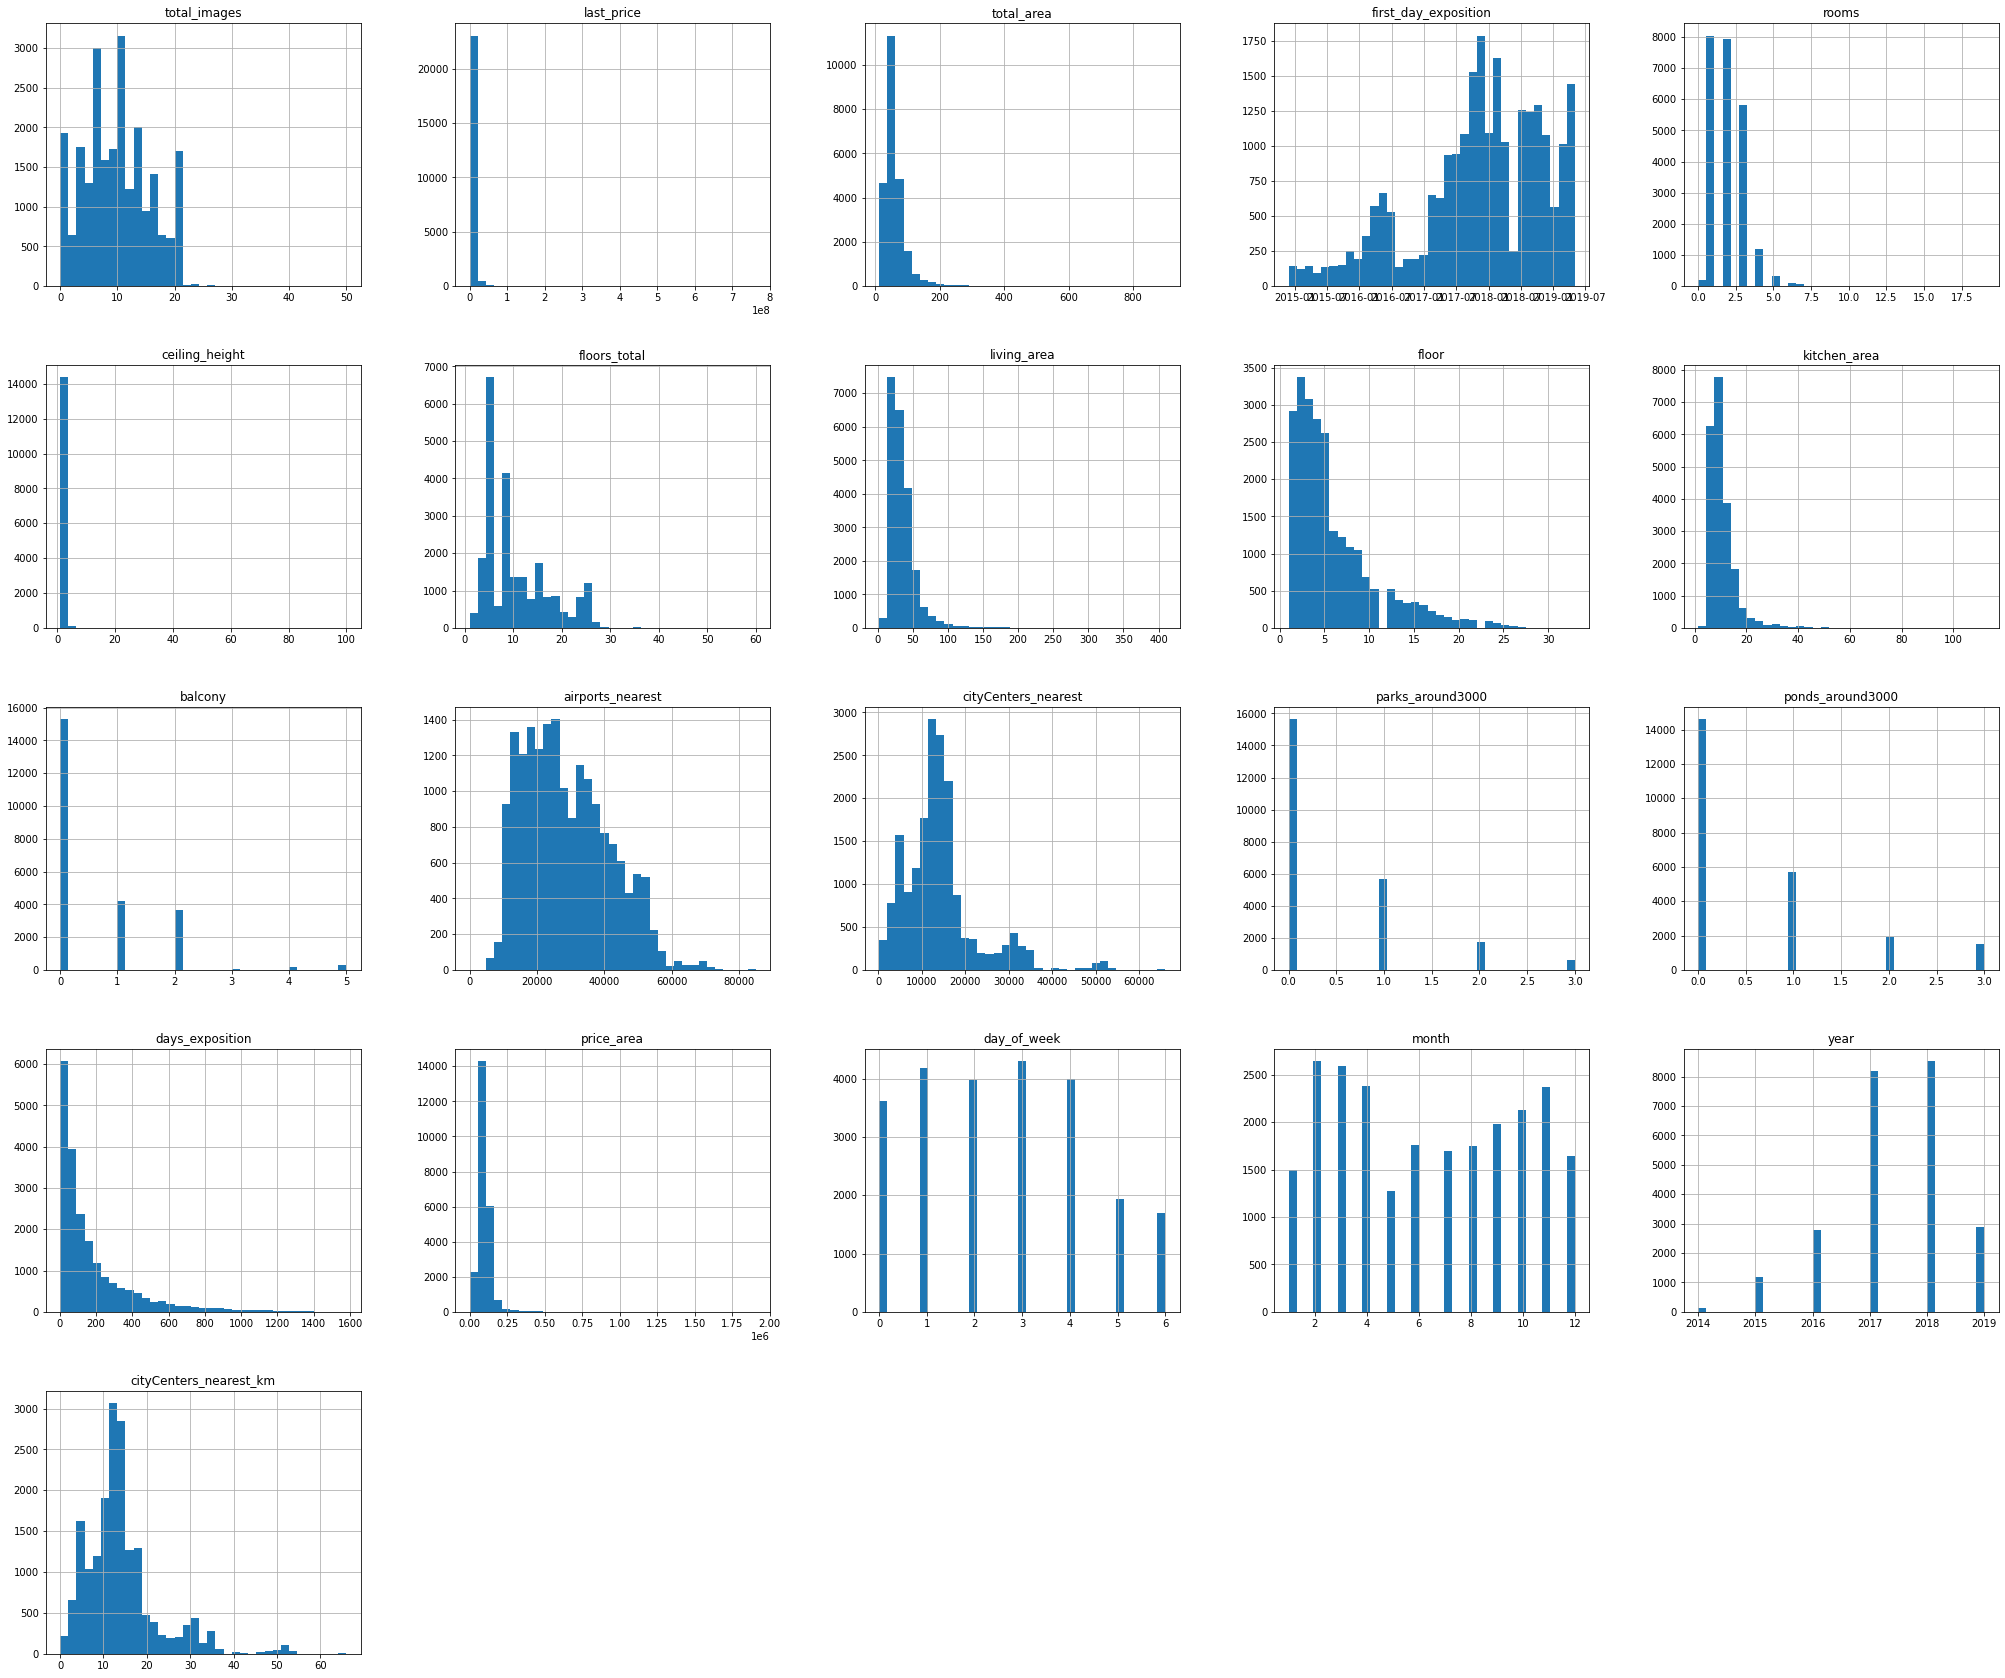

In [30]:
# Строим гистограммы
data.hist(figsize=(35, 30), bins=35)

# Отображаем график
plt.show()


В некоторых параметрах встречаются редкие и выбивающиеся значения. Нужно удалить их. Например, в столбце ceiling_height может быть указана высота потолков 25 м и 32 м. Логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м. Нужно обработать аномалии в столбцах, если они есть. 

In [31]:
# минимум и максимум для каждого столбца, чтобы понять диапазон значений
min_values = data.min()
max_values = data.max()

summary_df = pd.DataFrame({
    'Min': min_values,
    'Max': max_values
})

print(summary_df)


                                        Min                  Max
total_images                              0                   50
last_price                          12190.0          763000000.0
total_area                             12.0                900.0
first_day_exposition    2014-11-27 00:00:00  2019-05-03 00:00:00
rooms                                     0                   19
ceiling_height                          1.0                100.0
floors_total                              1                   60
living_area                             2.0                409.7
floor                                     1                   33
is_apartment                          False                 True
studio                                False                 True
open_plan                             False                 True
kitchen_area                            1.3                112.0
balcony                                   0                    5
locality_name            

In [32]:
# функция для удаления аномалий в числовых столбцах, используя метод на основе среднего и стандартного отклонения.

def anomalia(data, columns): 
    for column in columns:  
        mean = data[column].mean()
        std = data[column].std()
            
        #границы для аномалий
        lower_bound = mean - std / 10
        upper_bound = mean + std / 10

        cleaned_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    return cleaned_data


columns_c = [
    'total_area',       # общая площадь
    'living_area',      # жилая площадь
    'kitchen_area',     # площадь кухни
    'last_price',       # цена объекта
    'rooms',            # количество комнат
    'ceiling_height',   # высота потолков
    'floor',            # тип этажа квартиры 
    'floors_total',     # общее количество этажей в доме
    'cityCenters_nearest',  # расстояние до центра города в метрах
    'parks_nearest'    # расстояние до ближайшего парка
    
]


cleaned_data = anomalia(data, columns_c)
print(cleaned_data)

       total_images  last_price  total_area first_day_exposition  rooms  \
0                20  13000000.0       108.0           2019-03-07      3   
23               11   2950000.0        32.0           2016-10-29      1   
36               13   3790000.0        45.0           2017-01-25      2   
93               10   3500000.0        40.4           2016-06-15      1   
109               2   7497600.0        62.5           2015-12-08      2   
...             ...         ...         ...                  ...    ...   
23608            22  14000000.0        80.0           2017-11-10      3   
23625            12   6700000.0        42.0           2019-02-13      2   
23629             4   5650000.0        54.0           2017-04-30      2   
23659            11   4900000.0        60.0           2015-12-15      3   
23681            13   5250000.0        43.0           2018-05-11      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0                2.70

In [33]:
# минимум и максимум для каждого столбца, чтобы понять диапазон значений
min1 = cleaned_data.min()
max1 = cleaned_data.max()

summary = pd.DataFrame({
    'Min': min1,
    'Max': max1
})

print(summary)


                                        Min                  Max
total_images                              0                   22
last_price                        2150000.0          330000000.0
total_area                             21.0                517.0
first_day_exposition    2014-11-27 00:00:00  2019-05-02 00:00:00
rooms                                     0                   16
ceiling_height                          2.0                  6.0
floors_total                              2                   28
living_area                             6.5                332.0
floor                                     1                   25
is_apartment                          False                 True
studio                                False                 True
open_plan                             False                 True
kitchen_area                            4.0                 72.0
balcony                                   0                    5
locality_name            

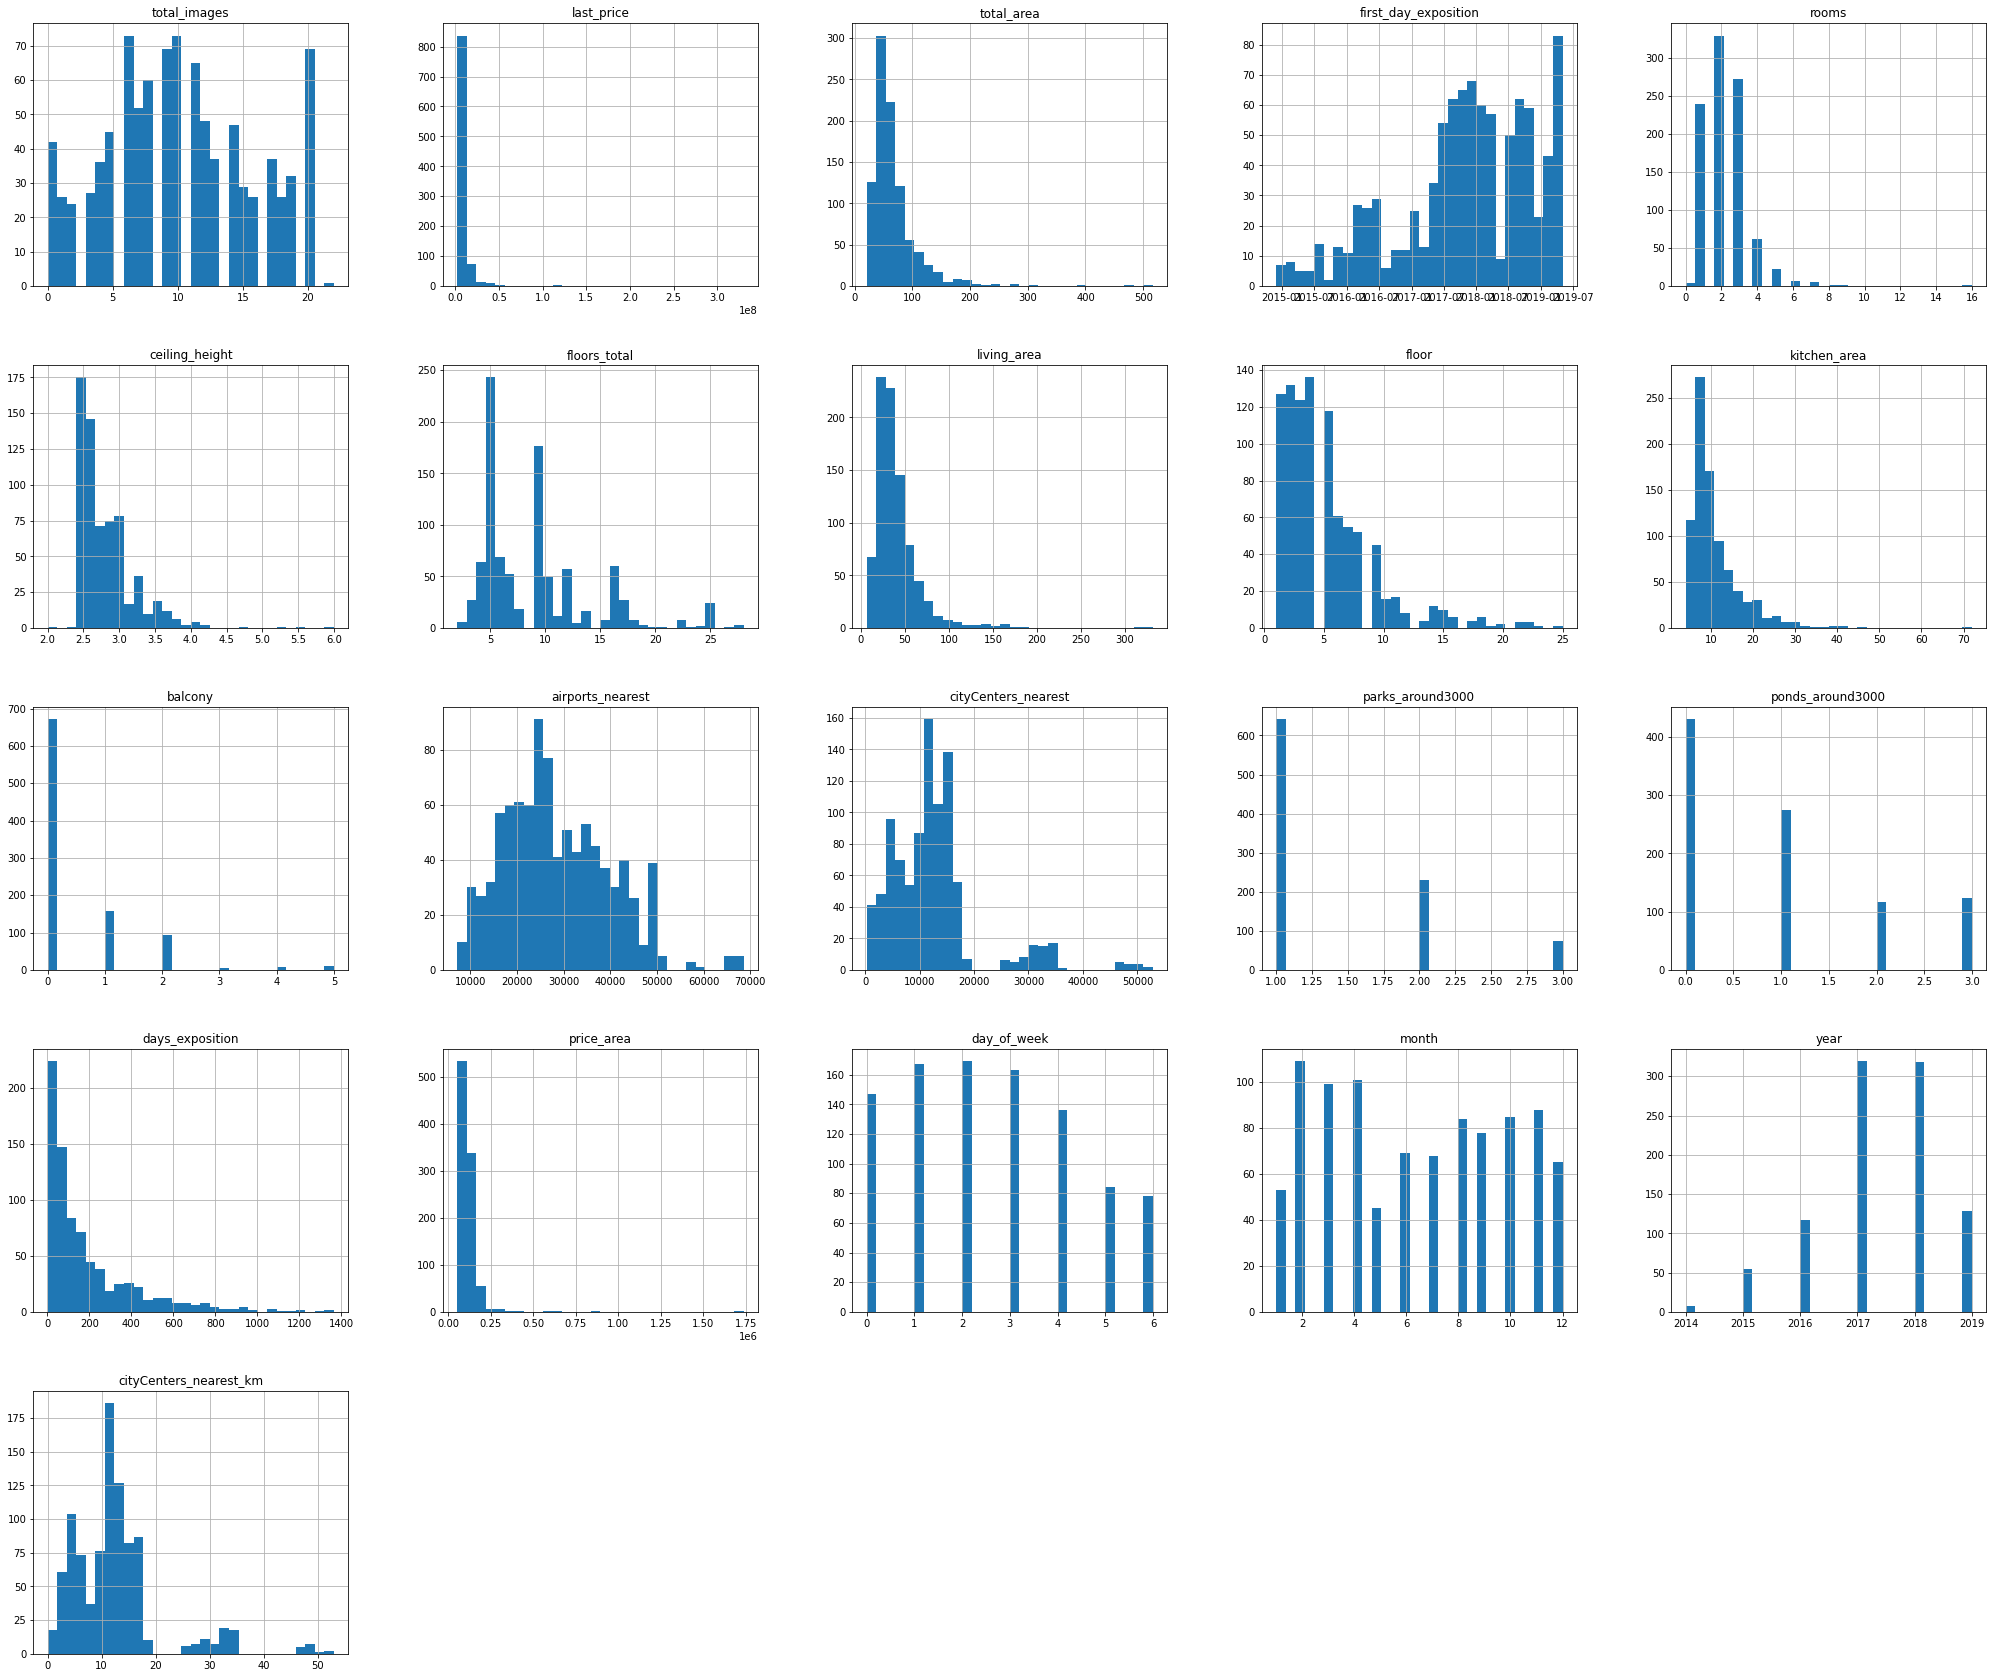

In [34]:
# Строим гистограммы
cleaned_data.hist(figsize=(35, 30), bins=30)

# Отображаем график
plt.show()

Вот мои наблюдения по изменениям параметров после удаления аномалий:

1. **total_images**:  
   Максимум уменьшился с 50 до 22, что говорит о том, что были удалены объекты с большим количеством изображений, возможно, чрезмерным.

2. **last_price**:  
   Минимальная цена изменилась с 12 190 до 2 150 000, что указывает на удаление аномальных или ошибочных данных с крайне низкими ценами. Максимальная цена снизилась, что может свидетельствовать о том, что были исключены объекты с нереалистично высокими ценами.

3. **total_area**:  
   Минимальная площадь увеличилась с 12 м² до 21 м², что показывает исключение маленьких объектов (например, студий или очень компактных квартир). Максимальное значение уменьшилось, что указывает на удаление экстремальных значений площади.

4. **first_day_exposition**:  
   Значения остались в пределах 2014-2019 годов.
   
5. **rooms**:  
   Минимальное количество комнат увеличилось с 0 до 1, что показывает исключение объявлений без комнат или с некорректно указанным количеством. Максимальное значение уменьшилось с 19 до 16.

6. **ceiling_height**:  
   Минимальное значение увеличилось с 1 м до 2 м, что устраняет некорректные данные о слишком низких потолках.
   
7. **floors_total**:  
   Максимум снизился с 60 до 28, что показывает исключение объектов с слишком большим количеством этажей.

8. **living_area**:  
   Минимальное значение увеличилось с 2 м² до 6.5 м², что устраняет маленькие квартиры. 

9. **floor**:  
   Максимум уменьшился с 33 до 25, что указывает на удаление объектов с аномально высокими этажами.

10. **is_apartment, studio, open_plan**:  
    Эти параметры не изменились в значениях.

11. **kitchen_area**:  
    Минимальное значение увеличилось с 1.3 м² до 4 м², что показывает исключение объектов с минимальной площадью кухни.

12. **balcony**:  
    Значения не изменились значительно, максимальное количество балконов осталось на уровне 5, что нормально для большинства объектов.

13. **parks_around3000, ponds_around3000**:  
    Минимальное количество парков и водоемов осталось на уровне 0, что логично для объектов в районах без этих объектов поблизости.

14. **parks_nearest, ponds_nearest**:  
    Минимальные значения увеличились (от 1 м до 457 м для парков, от 13 м до 20 м для водоемов), что указывает на исключение объектов с аномально маленьким расстоянием. 

15. **price_area**:  
    Минимальное значение увеличилось, что указывает на удаление объектов с крайне низкими ценами за квадратный метр. Максимум также снизился, что связано с исключением объектов с аномально высокой ценой за квадратный метр.

16. **day_of_week, month, year**:  
    Эти параметры не изменились, так как они представляют собой категориальные данные, которые можно использовать для анализа сезонности и трендов.

В целом, удаление аномалий позволило привести данные к более логичным и достоверным значениям, что улучшает их качество и делает анализ более точным.

Изучим, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление. 

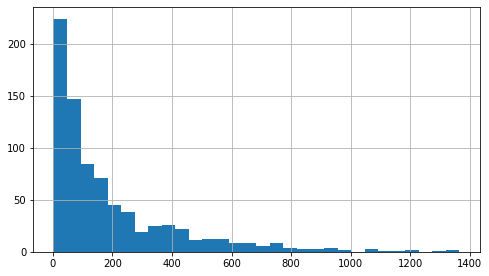

In [35]:
# Строим гистограмму
cleaned_data['days_exposition'].hist(figsize=(8, 4.5), bins=30)

# Отображаем график
plt.show()

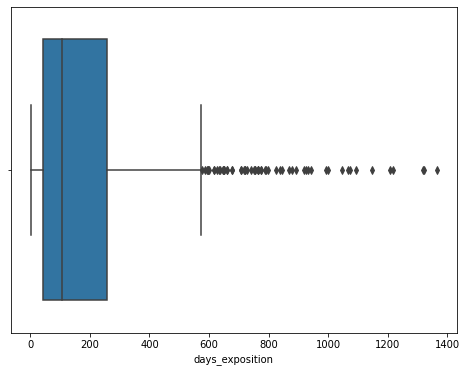

In [36]:
# Boxplot для 'days_exposition'
plt.figure(figsize=(8, 6))
sns.boxplot(x=cleaned_data['days_exposition'])
plt.show()

**Boxplot (ящик с усами)** помогает понять распределение данных и выявить выбросы:

1. **Ящик**: показывает 50% данных между 1-м (Q1) и 3-м (Q3) квартилями. **Медиана** (линия внутри ящика) делит данные пополам.
2. **Усы**: показывают диапазон данных, не считая выбросами (1.5 * IQR от Q1 и Q3).
3. **Выбросы**: точки за пределами усов считаются выбросами (аномальными значениями).


In [37]:
# Рассчитываем 1-й и 3-й квартиль и IQR
Q1 = cleaned_data['days_exposition'].quantile(0.25)
Q3 = cleaned_data['days_exposition'].quantile(0.75)
IQR = Q3 - Q1

# Определяем пределы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Находим выбросы
outliers = cleaned_data[(cleaned_data['days_exposition'] < lower_bound) | (cleaned_data['days_exposition'] > upper_bound)]

print(f"Количество выбросов: {len(outliers)}")
print(outliers)


Количество выбросов: 59
       total_images  last_price  total_area first_day_exposition  rooms  \
23               11   2950000.0       32.00           2016-10-29      1   
109               2   7497600.0       62.50           2015-12-08      2   
201               5  10880000.0      123.10           2015-11-12      6   
213              11   8700000.0      111.40           2016-10-10      4   
559              10   8100000.0       70.80           2015-02-11      3   
744              16   5500000.0       42.60           2016-03-09      1   
1531             20  22315000.0      145.00           2015-05-21      4   
1564              2   9950000.0       71.00           2015-08-23      2   
1566             15  16000000.0      110.00           2016-02-27      4   
2249             12   4650000.0       44.00           2015-12-08      2   
3545              6  13700000.0      154.40           2017-02-02      7   
3589             14   6300000.0       42.00           2016-10-14      2   
3

In [38]:
min_values = cleaned_data['days_exposition'].min()
max_values = cleaned_data['days_exposition'].max()
mean_values = cleaned_data['days_exposition'].mean()
median_values = cleaned_data['days_exposition'].median()

print('min:', min_values)
print('max:', max_values)
print('mean:', mean_values)
print('median:', median_values)

min: 2.0
max: 1365.0
mean: 193.87373737373738
median: 104.5


Продажа квартиры может занять от 2 до 1365 дней, что обусловлено различными факторами, влияющими на скорость сделки. Выбросы в данных, такие как продажи, продолжавшиеся более года (например, 1365 дней), могут быть вызваны несколькими причинами:

1. **Нереалистичная цена**: Если квартира выставлена по завышенной цене, это может сильно затруднить продажу. Продажа по высокой цене может затянуться на долгие месяцы или даже годы, пока не будут сделаны корректировки.

2. **Низкая ликвидность объекта**: Например, если квартира имеет нестандартную планировку или расположена в районе с малым количеством покупателей, это может затруднить поиск покупателя.

3. **Состояние рынка недвижимости**: Экономические условия, спрос и предложение на рынке недвижимости, сезонность (например, зимние месяцы могут быть менее активными для покупок) — все это может существенно влиять на срок экспозиции недвижимости.

4. **Неправильное представление данных**: Неверная агрегация или обработка данных, например, неправильная группировка, округление или масштабирование.

5. **Ошибки сбора данных**: Проблемы в процессе сбора данных, такие как сбой в ПО или неправильная настройка инструментов. Также пропущенные значения, которые затем заполняются неправильно (например, на основе статистических методов).

Эти выбросы в данных могут искажать средние показатели, поэтому медианное значение в 104.5 дня является более репрезентативным для типичных сроков продажи.

**Резюме:**
- В среднем квартиры продаются за 3-6 месяцев, при этом сделки, заключенные в течение месяца, можно считать быстрыми, а продажи, которые продолжаются год и более, являются долгими.

Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта.

In [39]:
corr = cleaned_data.corr()
print(corr['last_price'].sort_values(ascending=False))

last_price                1.000000
price_area                0.893800
total_area                0.549694
kitchen_area              0.506699
living_area               0.469524
ceiling_height            0.377179
rooms                     0.319658
ponds_around3000          0.209544
parks_around3000          0.172653
total_images              0.099974
days_exposition           0.087569
is_apartment              0.028557
month                     0.013323
floor                     0.010355
year                      0.000588
balcony                  -0.001450
open_plan                -0.018232
studio                   -0.018484
day_of_week              -0.019604
floors_total             -0.038412
airports_nearest         -0.049749
cityCenters_nearest      -0.205262
cityCenters_nearest_km   -0.205371
Name: last_price, dtype: float64


Изучим, зависит ли цена от:
  общей площади;
  жилой площади;
  площади кухни;
  количества комнат;
  этажа, на котором расположена квартира (первый, последний, другой);
  даты размещения (день недели, месяц, год).

In [61]:
correlation = cleaned_data[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'type_floor', 
                           'first_day_exposition', 'ceiling_height']].corr()

print(correlation['last_price'].sort_values(ascending=False))


last_price        1.000000
total_area        0.549694
kitchen_area      0.506699
living_area       0.469524
ceiling_height    0.377179
rooms             0.319658
Name: last_price, dtype: float64


Отрицательная корреляция говорит об обратной зависимости, положительная - о прямой. Чем ближе к нулю, тем она меньше.

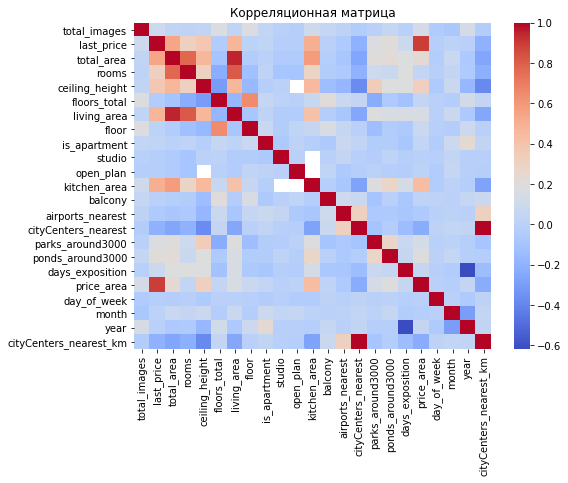

In [41]:
# Построение тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

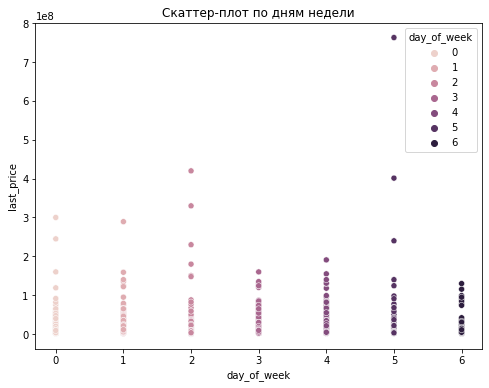

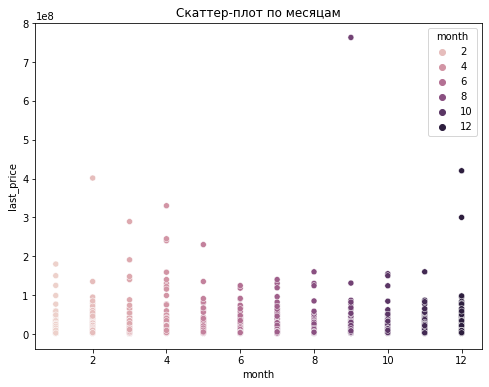

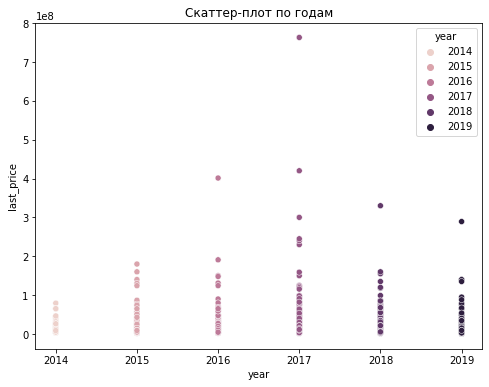

In [55]:
# Скаттер-плот для day_of_week
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='day_of_week', y='last_price', hue='day_of_week')
plt.title('Скаттер-плот по дням недели')
plt.show()

# Скаттер-плот для month
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='month', y='last_price', hue='month')
plt.title('Скаттер-плот по месяцам')
plt.show()

# Скаттер-плот для year
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='year', y='last_price', hue='year')
plt.title('Скаттер-плот по годам')
plt.show()


Построим графики, которые покажут зависимость цены от указанных выше параметров. 

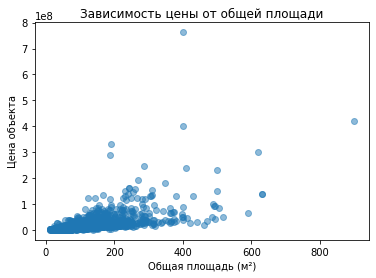

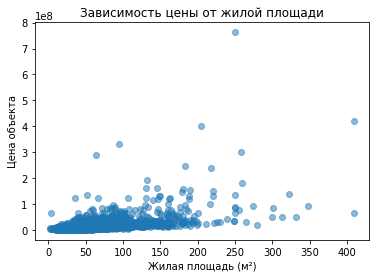

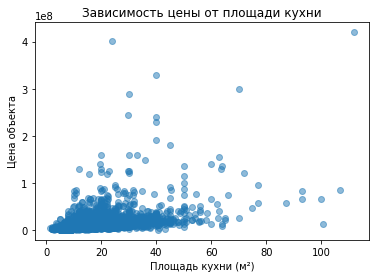

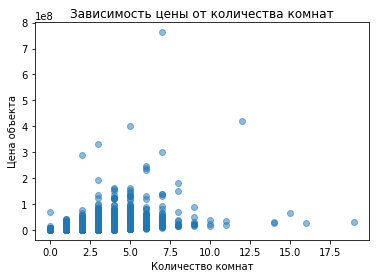

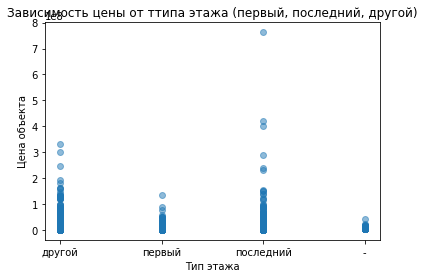

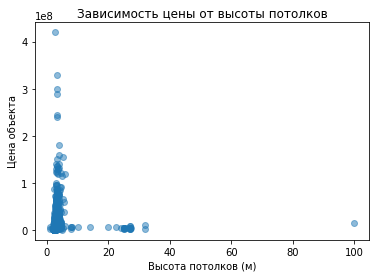

In [43]:
# Общая площадь
plt.scatter(data['total_area'], data['last_price'], alpha=0.5)
plt.title('Зависимость цены от общей площади')
plt.xlabel('Общая площадь (м²)')
plt.ylabel('Цена объекта')
plt.show()

# Жилая площадь
plt.scatter(data['living_area'], data['last_price'], alpha=0.5)
plt.title('Зависимость цены от жилой площади')
plt.xlabel('Жилая площадь (м²)')
plt.ylabel('Цена объекта')
plt.show()

# Площадь кухни
plt.scatter(data['kitchen_area'], data['last_price'], alpha=0.5)
plt.title('Зависимость цены от площади кухни')
plt.xlabel('Площадь кухни (м²)')
plt.ylabel('Цена объекта')
plt.show()

# Количество комнат
plt.scatter(data['rooms'], data['last_price'], alpha=0.5)
plt.title('Зависимость цены от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена объекта')
plt.show()

# Тип этажа
plt.scatter(data['type_floor'], data['last_price'], alpha=0.5)
plt.title('Зависимость цены от ттипа этажа (первый, последний, другой)')
plt.xlabel('Тип этажа')
plt.ylabel('Цена объекта')
plt.show()

# Высота потолков
plt.scatter(data['ceiling_height'], data['last_price'], alpha=0.5)
plt.title('Зависимость цены от высоты потолков')
plt.xlabel('Высота потолков (м)')
plt.ylabel('Цена объекта')
plt.show()


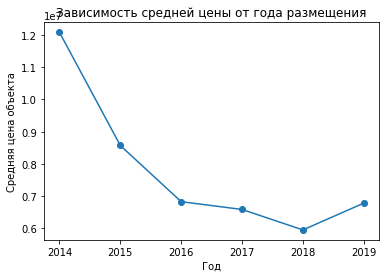

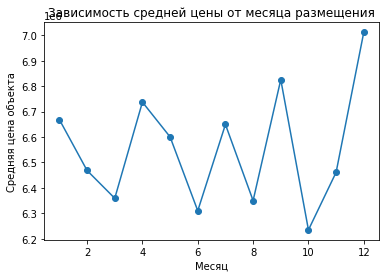

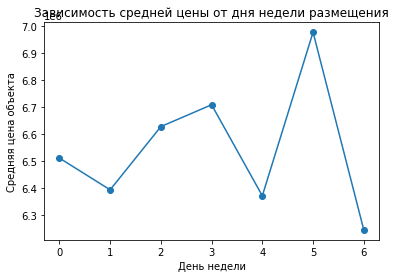

In [44]:
# Год
year_mean_price = data.groupby('year')['last_price'].mean()

plt.plot(year_mean_price.index, year_mean_price.values, marker='o')
plt.title('Зависимость средней цены от года размещения')
plt.xlabel('Год')
plt.ylabel('Средняя цена объекта')
plt.show()

# Месяц
month_mean_price = data.groupby('month')['last_price'].mean()

plt.plot(month_mean_price.index, month_mean_price.values, marker='o')
plt.title('Зависимость средней цены от месяца размещения')
plt.xlabel('Месяц')
plt.ylabel('Средняя цена объекта')
plt.show()

# День недели
day_of_week_mean_price = data.groupby('day_of_week')['last_price'].mean()

plt.plot(day_of_week_mean_price.index, day_of_week_mean_price.values, marker='o')
plt.title('Зависимость средней цены от дня недели размещения')
plt.xlabel('День недели')
plt.ylabel('Средняя цена объекта')
plt.show()

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений — построим сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.
 

In [45]:
data['price_mean'] = data['last_price'] / data['total_area']
print(data['price_mean'])

0        120370.370370
1         82920.792079
2         92785.714286
3        408176.100629
4        100000.000000
             ...      
23694     72490.845228
23695     52542.372881
23696     44091.710758
23697    149511.400651
23698     41795.665635
Name: price_mean, Length: 23699, dtype: float64


In [46]:
# топ-10 населённых пунктов
locality_counts = data['locality_name'].value_counts()

top_10_localities = locality_counts.head(10).reset_index()
top_10_localities.columns = ['locality_name', 'count']
print(top_10_localities) 

       locality_name  count
0    Санкт-Петербург  15721
1     поселок Мурино    556
2     поселок Шушары    440
3         Всеволожск    398
4             Пушкин    369
5            Колпино    338
6  поселок Парголово    327
7            Гатчина    307
8    деревня Кудрово    299
9             Выборг    237


In [47]:
# Сводная таблица для населённых пунктов
pivot_table = data.pivot_table(
    index='locality_name',
    values='price_mean',
    aggfunc=['count', 'mean']
)

# только 10 населённых пунктов
pivot_table = pivot_table.loc[top_10_localities['locality_name']]

pivot_table.columns = ['count', 'mean']
print(pivot_table)



                   count           mean
locality_name                          
Санкт-Петербург    15721  114849.008794
поселок Мурино       556   85681.762601
поселок Шушары       440   78677.364217
Всеволожск           398   68654.473986
Пушкин               369  103125.819291
Колпино              338   75424.579098
поселок Парголово    327   90175.913458
Гатчина              307   68746.146763
деревня Кудрово      299   92473.547576
Выборг               237   58141.909153


Ранее мы посчитали расстояние до центра в километрах (cityCenters_nearest_km). Теперь выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим их среднюю стоимость на разном удалении от центра. Учтем каждый километр расстояния: среднюю цену квартир в одном километре от центра, в двух и так далее. 

In [48]:
data = data.dropna(subset=['cityCenters_nearest_km'])

# преобразуем в float, округляем и возвращаем в Int64
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].astype(float).round().astype('Int64')

print(data['cityCenters_nearest_km'].head())

# Группируем по расстоянию и считаем среднюю цену
result = data[data['locality_name'] == 'Санкт-Петербург'].groupby('cityCenters_nearest_km')['last_price'].mean().round()
print(result.head())

0    16
1    19
2    14
3     7
4     8
Name: cityCenters_nearest_km, dtype: Int64
cityCenters_nearest_km
0    31449116.0
1    21206721.0
2    17788320.0
3    11126581.0
4    13304280.0
Name: last_price, dtype: float64


Опишем, как стоимость объектов зависит от расстояния до центра города — построим график изменения средней цены для каждого километра от центра Петербурга.

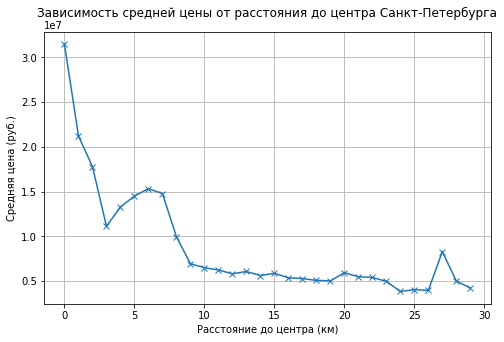

In [63]:
# Строим график
plt.figure(figsize=(8, 5))
plt.plot(result.index, result.values, marker='x')

plt.title('Зависимость средней цены от расстояния до центра Санкт-Петербурга', pad=15)
plt.xlabel('Расстояние до центра (км)')
plt.ylabel('Средняя цена (руб.)')
plt.grid(True)
plt.show()


Зависимость стоимости объектов от расстояния до центра города демонстрирует положительную корреляцию. То есть, чем дальше объект находится от центра города, тем ниже его стоимость. Это явление объясняется несколькими факторами.

В центре города сосредоточены ключевые инфраструктурные объекты, такие как деловые, коммерческие и культурные центры, а также развитое транспортное сообщение, что делает районы более привлекательными для проживания и бизнеса.

Однако стоит отметить, что эта зависимость может изменяться в зависимости от ряда факторов. Например, если в отдалённой части города активно развиваются новые инфраструктурные проекты, строятся транспортные сети или жилые комплексы с удобствами, то стоимость объектов может увеличиться. 

Вывод

## Общий вывод

В ходе исследовательского анализа данных, содержащих информацию о продаже квартир в Санкт-Петербурге и соседних населённых пунктах, были выявлены ключевые факторы, влияющие на стоимость недвижимости, а также проведена обработка данных и анализ.

### Обработка данных
1. **Пропущенные значения**: Пропуски были обнаружены в столбцах, таких как количество балконов, площадь кухни и высота потолков. Были использованы логичные подходы для замены пропущенных значений (например, для числа балконов — значение 0, если не указано иное). Для других столбцов, где невозможно было предложить адекватное решение, пропуски оставлены, так как они также являются важным сигналом в анализе.
   
2. **Типы данных**: Были изменены типы данных для нескольких столбцов, чтобы они корректно отражали информацию (например, для даты публикации был изменён тип на `datetime`, а для некоторых столбцов с целочисленными значениями — на `Int64`).

3. **Неявные дубликаты**: Были обработаны неявные дубликаты в названиях населённых пунктов, чтобы избежать избыточности и привести данные к единому формату.

### Анализ и визуализация данных
1. **Гистограммы и аномалии**: Были построены гистограммы для различных параметров, таких как площадь квартиры, цена, высота потолков и другие. В процессе визуализации были выявлены аномальные значения, такие как слишком большие или малые значения для высоты потолков и площади. Эти аномалии были обработаны — исправлены или удалены.

2. **Время продажи квартир**: Среднее время размещения объявления о продаже составило около 194 дней, а медиана — 104.5 дня. Быстрыми продажами можно считать сделки, завершённые в течение месяца, а долгими — те, что занимают более года.

3. **Факторы, влияющие на цену**: 
   - **Общая площадь**: Чем больше площадь квартиры, тем выше её стоимость.
   - **Жилая площадь**: Жилая площадь также оказывает влияние на цену, но не так значительно, как общая.
   - **Этаж**: Квартиры на первых и последних этажах имеют тенденцию быть дешевле, чем те, что расположены на других этажах.
   - **Количество комнат**: С увеличением числа комнат цена квартиры возрастает.
   - **Местоположение**: Стоимость квартир в непосредственной близости от центра города значительно выше, чем на удалении от него.
   - **Дополнительные факторы**: Наличие парков, водоёмов и других объектов в районе квартиры также влияет на её цену, но менее значительно.

4. **Средняя цена на квадратный метр**: Средняя цена квадратного метра варьируется в зависимости от района. В некоторых населённых пунктах, таких как Санкт-Петербург, цена квадратного метра значительно выше, чем в других.

5. **Зависимость цены от расстояния до центра**: Влияние расстояния до центра города на стоимость квартир было выраженным — чем дальше от центра, тем дешевле квартиры, с постепенным снижением цен на каждом километре от города.

### Итог
Изучив данные о продаже квартир, можно выделить несколько важных факторов, которые влияют на цену объекта:
- Географическое расположение: расстояние до центра города и наличие инфраструктуры (парков, водоёмов и т.д.).
- Характеристики самой квартиры: площадь, этаж, количество комнат.
- Время размещения объявления также играет роль, так как длительные продажи могут свидетельствовать о завышенной цене или низком спросе.
